In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

import os
import tensorflow as tf
import keras
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers , models, optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.applications import ResNet50V2

In [2]:
train_dir =r'D:\JN2\train'
test_dir =r'D:\JN2\test'

def Classes_Count( path, name):
    Classes_Dict = {}
    
    for Class in os.listdir(path):
        
        Full_Path = path +"/"+ Class
        Classes_Dict[Class] = len(os.listdir(Full_Path))
        
    df = pd.DataFrame(Classes_Dict, index=[name])
    
    return df

Train_Count = Classes_Count(train_dir, 'Train').transpose().sort_values(by="Train", ascending=False)
Test_Count = Classes_Count(test_dir, 'Test').transpose().sort_values(by="Test", ascending=False)

In [8]:
# specifing new image shape for resnet
img_shape = 48
batch_size = 128
train_data_path = r'D:\JN2\train'
test_data_path = r'D:\JN2\test'


In [9]:
train_preprocessor = ImageDataGenerator(
        rescale = 1 / 255.,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,                                        
        fill_mode='nearest',
    )


test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

train_data = train_preprocessor.flow_from_directory(
    train_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode='rgb',
    shuffle=True,
    batch_size=batch_size,
    subset='training', 
)

test_data = test_preprocessor.flow_from_directory(
    test_data_path,
    class_mode="categorical",
    target_size=(img_shape,img_shape),
    color_mode="rgb",
    shuffle=False,
    batch_size=batch_size,
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [10]:
# Example: Get class names from a DirectoryIterator
class_indices = train_data.class_indices
class_names = list(class_indices.keys())
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [11]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
import tensorflow as tf
tf.random.set_seed(42)
np.random.seed(42)
# Load ResNet50 model with pretrained weights and without the top classification layers
pretrained_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze the layers in the pretrained model
for layer in pretrained_model.layers:
    layer.trainable = False

# Create a new Sequential model
resnet_model = tf.keras.Sequential()

# Add the pretrained ResNet50 model to the new model
resnet_model.add(pretrained_model)

# Add GlobalAveragePooling2D layer to flatten the output
resnet_model.add(GlobalAveragePooling2D())

# Add a dense layer with 512 units and ReLU activation
resnet_model.add(Dense(512, activation='relu'))

# Add the output layer with appropriate units and activation for your task
resnet_model.add(Dense(7, activation='softmax'))  # Replace 7 with your actual number of classes

# Build the model with a specific input shape
input_shape = (48, 48, 3)
resnet_model.build((None, *input_shape))  # None is for batch size
# Compile the model with optimizer, loss, and metrics
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Print the model summary
resnet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 2, 2, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,617,479 (93.91 MB)

 Trainable params: 1,052,679 (4.02 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [12]:
from tensorflow.keras.optimizers import Adam
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [13]:
epochs = 20
history = resnet_model.fit(
    train_data,
    validation_data=test_data,
    epochs=epochs
)

Epoch 1/20


C:\Users\thala\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 1409s 6s/step - accuracy: 0.2890 - loss: 1.9965 - val_accuracy: 0.3734 - val_loss: 1.6132
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 960s 4s/step - accuracy: 0.3618 - loss: 1.6293 - val_accuracy: 0.3905 - val_loss: 1.5870
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 799s 4s/step - accuracy: 0.3716 - loss: 1.6021 - val_accuracy: 0.3947 - val_loss: 1.5744
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 756s 3s/step - accuracy: 0.3738 - loss: 1.5894 - val_accuracy: 0.4076 - val_loss: 1.5511
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 751s 3s/step - accuracy: 0.3874 - loss: 1.5647 - val_accuracy: 0.3977 - val_loss: 1.5564
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 756s 3s/step - accuracy: 0.3975 - loss: 1.5470 - val_accuracy: 0.4100 - val_loss: 1.5353
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 877s 4s/step - accuracy: 0.3949 - loss: 1.5459 - val_accuracy: 0.4217 - val_loss: 1.5193
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 970s 4s/step - accuracy: 0.4110 - loss: 1.5342 - val_accuracy: 0.41

In [16]:
# Model Evaluate 
train_loss,train_accuracy=resnet_model.evaluate(train_data)
test_loss,test_accuracy=resnet_model.evaluate(test_data)
print(" final train  accuracy= {:.2f}, validation accuracy={:.2f}".format(train_accuracy*100,test_accuracy*100))

225/225 ━━━━━━━━━━━━━━━━━━━━ 713s 3s/step - accuracy: 0.4317 - loss: 1.4771
57/57 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.3601 - loss: 1.6080
 final train  accuracy= 43.20, validation accuracy=42.45


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Define the directory path where your test data is located
test_data_dir =  r'D:\JN2\test'

# Create an ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)  # You can add other preprocessing steps here if needed

# Load test data using flow_from_directory
test_data_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(48, 48),  # Adjust the target size to match your model's input size
    batch_size=32,
    class_mode='categorical',  # Use 'categorical' for classification problems
    shuffle=False  # Important: set shuffle to False for test data to keep labels in order
)

# Concatenate the batches to get the full test data and labels
test_data_array = []
test_labels = []

try:
    for i in range(len(test_data_generator)):
        data, labels = test_data_generator[i]
        test_data_array.append(data)
        test_labels.append(labels)
    
    # Concatenate batches to get the full test data and labels
    test_data_array = np.concatenate(test_data_array)
    test_labels = np.concatenate(test_labels)
    
    # Print the shape of test data and labels to verify
    print('Test data shape:', test_data_array.shape)
    print('Test labels shape:', test_labels.shape)

    # Make predictions
    predictions = resnet_model.predict(test_data_array)

    # Convert predictions and true labels to class labels
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    # Calculate and print classification report
    print(classification_report(true_labels, predicted_labels))

    # Calculate and print confusion matrix
    print(confusion_matrix(true_labels, predicted_labels))

except Exception as e:
    print("Error occurred:", e)

Found 7178 images belonging to 7 classes.
Test data shape: (7178, 48, 48, 3)
Test labels shape: (7178, 7)
225/225 ━━━━━━━━━━━━━━━━━━━━ 183s 781ms/step
              precision    recall  f1-score   support

           0       0.28      0.24      0.26       958
           1       0.73      0.07      0.13       111
           2       0.28      0.26      0.27      1024
           3       0.51      0.68      0.58      1774
           4       0.42      0.40      0.41      1233
           5       0.40      0.29      0.34      1247
           6       0.51      0.58      0.54       831

    accuracy                           0.42      7178
   macro avg       0.45      0.36      0.36      7178
weighted avg       0.41      0.42      0.41      7178

[[ 230    1  146  259  114  136   72]
 [  23    8   13   41   11   10    5]
 [ 115    0  264  197  152  133  163]
 [ 110    1  106 1204  154  109   90]
 [ 133    0  122  267  498  126   87]
 [ 179    1  165  311  176  361   54]
 [  30    0  119  104   

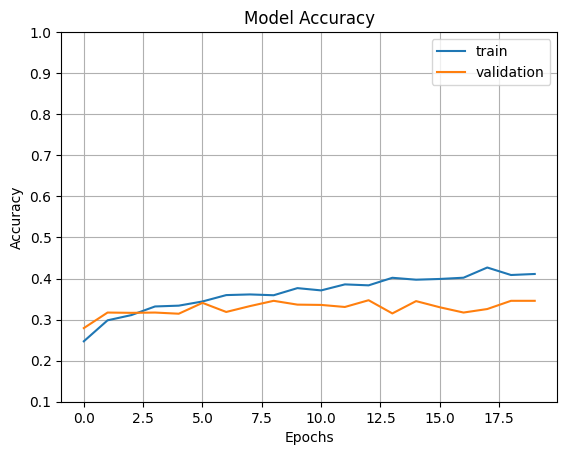

In [26]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.1,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])
plt.show() 